# LE49 Exercise1: Probabilistic Neural Networks

*Xiangyu Zhao*\
*Trinity College*\
*CRSid: xz398*

## Answers to Question (a)

### Part (i)

For the `RWiggle` model $Y_i\sim N(f_\theta(x_i),\sigma^2)$ the log likelihood of a single observation is

$$\log\Pr(y_i)=-\frac{1}{2}\log(2\pi\sigma^2)-\frac{1}{2\sigma^2}\left(y_i-f_\theta(x_i)\right)^2$$

We can take advantage of PyTorch to calculate the average log likelihood of the entire dataset

$$\frac{1}{n}\log\Pr(y_1,\cdots,y_n)=\frac{1}{n}\sum_{i=1}^n\log\Pr(y_i)$$

by calling
```python
loglik = torch.mean(rwiggle(y, x))
```
instead of having to derive a full formula of the log likelihood.

The ribbon plot of the fitted `RWiggle` model to the xkcd dataset after training for 50000 epochs is:

![](Question(a)/RWiggle_plot.png)

### Part (ii)

For the heteroscedastic model $Y_i\sim N\big(f_\theta(x_i),\sigma^2_\phi(x_i)\big)$, which is implemented as `HWiggle` in the appendix, the log likelihood of a single observation becomes

$$\log\Pr(y_i)=-\frac{1}{2}\log\left(2\pi\sigma^2_\phi(x_i)\right)-\frac{1}{2\sigma^2_\phi(x_i)}\left(y_i-f_\theta(x_i)\right)^2$$

The code implementation of `HWiggle` should simply replace `self.σpre` by a neural network, where I used
```python
self.σpre = Wiggle()
```

The ribbon plot of the fitted `HWiggle` model to the xkcd dataset after training for 50000 epochs is:

![](Question(a)/HWiggle_plot.png)

## Answers to Question (b)

### Part (i)

If the `f` function were rich enough that it fits the dataset perfectly, then 

$$\forall i=1,\cdots,n.\ f_\theta(x_i)=y_i$$

Therefore for the `RWiggle` model:

$$\begin{aligned}
\log\Pr(y_1,\cdots,y_n) &= -\frac{n}{2}\log(2\pi\sigma^2)-\frac{1}{2\sigma^2}\sum_{i=1}^n\left(y_i-f_\theta(x_i)\right)^2 \\
    &= -\frac{n}{2}\log(2\pi\sigma^2)
\end{aligned}$$

Therefore when $\sigma=0$, the training log likelihood of the `RWiggle` model reaches its maximum, which is $+\infty$.

Similarly, for the `HWiggle` model:

$$\log\Pr(y_1,\cdots,y_n)=-\frac{1}{2}\sum_{i=1}^n\log\left(2\pi\sigma^2_\phi(x_i)\right)$$

When $\sigma_\phi(x)=0$, the training log likelihood of the `HWiggle` model also reaches its maximum, which is also $+\infty$.

### Part (ii)

The plots of training log likelihoods w.r.t. epochs for both models are:

![](Question(b)/loglik_plot.png)

The dips in the log likelihood for the `HWiggle` model is because during the training process, $\sigma_\phi(x_i)$ can occasionally be very close to zero for some $x_i$, which makes the $\frac{1}{2\sigma^2_\phi(x_i)}(y_i-f_\theta(x_i))^2$ term very large and dominate the entire sum of the log likelihoods, resulting in a very low log likelihood of the dataset.

The log likelihoods of the `HWiggle` model is in general higher than that of the `RWiggle` model, which is because the heteroscedasticity nature of the `HWiggle` model allows its $\sigma_\phi(x)$ to be small when appropriate, and hence reducing the $\frac{1}{2}\log\left(2\pi\sigma^2_\phi(x_i)\right)$ term.

## Answers to Question (c)

### Part (i)

Once the training of the autoencoder `model = GaussianEncoder(BernoulliImageGenerator(d=4))` is finished, it can use the following code to reconstruct images:
```python
# Use the encoder to output the parameters of the distribution 
# of the original image in the latent space
μ, σ = model(original) 
# Randomly sample from the above distribution in the latent space
ε = torch.randn_like(σ)      
z = µ + σ * ε                
# Use the decoder to output the probabilities for each pixel
p = model.f(z).detach()
# Generate images according to the above probabilities
x = torch.bernoulli(p)
```

The results of the reconstructed images from the autoencoder, after training for 5 epochs, are shown as follows, together with the original images and the probability map for the reconstructed images:

![](Question(c)/original_imgs.png)
![](Question(c)/reconstructed_imgs_1.png)
![](Question(c)/reconstructed_imgs_2.png)
![](Question(c)/reconstructed_imgs_3.png)

### Part (ii)

The reconstructed images of image 35508 with varying amounts of noises are as follows: (from left to right: original image, original image with noise added, probability map for the reconstructed image, reconstructed image sampled from Bernoulli distribution)

![](Question(c)/reconstructed_imgs_noise_0.05.png)
![](Question(c)/reconstructed_imgs_noise_0.1.png)
![](Question(c)/reconstructed_imgs_noise_0.2.png)
![](Question(c)/reconstructed_imgs_noise_0.5.png)
![](Question(c)/reconstructed_imgs_noise_1.png)

From the results we can see that:

* When the noise amount is small, the reconstructed image is more similar to the original image; as the noise amount increases, the reconstructed image becomes less similar to the original image.
* The style of the reconstructed images change smoothly as the noise amount increases (i.e. no significant deviation in style in the in-between reconstructed images).

### Part (iii)

The random images can be generated by randomly sampling from the latent space, using the following code:
```python
z = torch.randn_like(σ)
p = model.f(z).detach()
x = torch.bernoulli(p)
```

Output: (first row: probability maps for the reconstructed images; second row: reconstructed images sampled from Bernoulli distribution)

![](Question(c)/random_imgs.png)

### Part (iv)

Simple linear interpolation in the latent space:

$$z_j = z_0 + \frac{j}{m}(z_1 - z_0)$$

Code:
```python
imgs = [mnist[i][0] for i in [28001, 43876]]
imgs = torch.stack(imgs)
μ, σ = model(imgs)
ε = torch.randn_like(σ)
z = µ + σ * ε
lerp = [z[0]]
for j in range(1, 11):
    lerp.append(torch.lerp(z[0], z[1], j / 11))
lerp.append(z[1])
lerp = torch.stack(lerp)
```

Then, for each $z_j$, use the same way to generate $x_j$:
```python
p = model.f(z).detach()
x = torch.bernoulli(p)
```

Output: (first row: probability maps for the reconstructed images; second row: reconstructed images sampled from Bernoulli distribution)

![](Question(c)/lerp_imgs.png)

The results show that the reconstructed images also form an interpolating pattern, suggesting that the points that are close to each other in the latent space can also generate similar images.

## Answers to Question (d)

Monte Carlo approximation code:
```python
def loglik_lb_monte_carlo(model, x, m=100):
    μ,σ = model(x)
    kl = 0.5 * (μ**2 + σ**2 - torch.log(σ**2) - 1).sum(1)
    lls = []
    for i in range(m):
        ε = torch.randn_like(σ)
        lls.append(model.f.loglik(x, z=μ + σ * ε))
    ll = sum(lls) / len(lls)
    return ll - kl
```

50 most likely images and 50 least likely images are shown below:

![](Question(d)/most_likely_imgs.png)
![](Question(d)/least_likely_imgs.png)

Therefore the 1s are the most likely images, which is possibly due to the fact that 1 is the most simple and easy-recongisable digit; the least likely images contains some weird shape of digits, some of which are not recognisable even for a normal human like myself; there are also some digits in thick strokes and some digits with discontinuities at the boundaries in the least likely images.

## Answers to Question (e)

To evaluate an autoencoder, I should evaluate $\mathcal{L}_{lb}$ on the holdout dataset, which is the gold standard for model evaluation in machine learning. Also, to compare two autoencoders, I should evaluate $\mathcal{L}_{lb}$ of both models on the same holdout dataset, so that the result are not biased due to different datapoints.

Training and holdout $\mathcal{L}_{lb}$ for both autoencoders:

|  | Avg training $\mathcal{L}_{lb}$ | Avg holdout $\mathcal{L}_{lb}$ |
|---|---|---|
| d=4 | -131.0 | -129.3 |
| d=20 | -123.9 | -121.2 |

Therefore I can conclude that the autoencoder with d=20 for the latent space fits better to the MNIST dataset.

## Answers to Question (f)

The perfect sampling distribution is the posterior distribution $\tilde{Z}\sim(Z\ |\ X=x, Y=y)$.

Since the conditional generative model is just the previous generative model with a conditioning on $y$, the implementation of such a conditional autoencoder should simply add the extra dimensions for $y$ at the input layers of both the encoder and the decoder, and also add an argument `y` to the `forward` and `loglik` (or `loglik_lb`) methods. Since the `forward` method has already been conditioned on $y$, there is no need to change the log likelihood formula in `loglik` or `loglik_lb`.

Code implementation (I used one-hot encodings for $y$, which has 10 dimensions):
```python
class ConditionalBernoulliImageGenerator(nn.Module):
    def __init__(self, d=4):
        super().__init__()
        self.d = d
        self.f = nn.Sequential(
            nn.Linear(d + 10, 128),
            ...
        )

    def forward(self, z, y):
        return self.f(torch.cat((z, y), dim=1))

    def loglik(self, x, z, y):
        xr = self(z, y)
        return (x * torch.log(xr) + (1 - x) * torch.log(1 - xr)).sum((1, 2, 3))


class ConditionalGaussianEncoder(nn.Module):
    def __init__(self, decoder):
        super().__init__()
        self.d = decoder.d
        self.f = decoder
        self.g = nn.Sequential(
            nn.Linear(28 * 28 + 10, 512),
            ...
        )

    def forward(self, x, y):
        x = torch.flatten(x, start_dim=1)
        μτ = self.g(torch.cat((x, y), dim=1))
        μ, τ = μτ[:, :self.d], μτ[:, self.d:]
        return μ, torch.exp(τ/2)

    def loglik_lb(self, x, y):
        μ, σ = self(x, y)
        kl = 0.5 * (μ**2 + σ**2 - torch.log(σ**2) - 1).sum(1)
        ε = torch.randn_like(σ)
        ll = self.f.loglik(x, z=μ + σ * ε, y=y)
        return ll - kl
```

Output of four different stylistically-similar sets of digits: (top row: probability map of the image; bottom row: generated image sampled from Bernoulli distribution):

![](Question(f)/style_1.png)
![](Question(f)/style_2.png)
![](Question(f)/style_3.png)
![](Question(f)/style_4.png)

## Appendix: Full Source Code

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
import torchvision
import pickle
import IPython

In [3]:
def init_random_seed(seed=309):
    np.random.seed(seed)
    torch.manual_seed(seed)

In [3]:
# Datasets
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

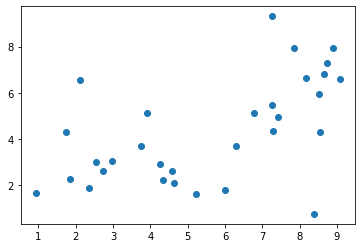

In [4]:
url = 'https://www.cl.cam.ac.uk/teaching/2122/DataSci/data/xkcd.csv'
xkcd = pd.read_csv(url)

plt.scatter(xkcd.x, xkcd.y)
plt.show()

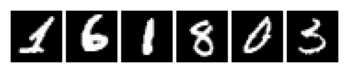

In [4]:
mnist = torchvision.datasets.MNIST(
    root = 'pytorch-data/',  # where to put the files
    download = True,         # if files aren't here, download them
    train = True,            # whether to import the test or the train subset
    # PyTorch uses PyTorch tensors internally, not numpy arrays, so convert them.
    transform = torchvision.transforms.ToTensor()
)

# Images can be plotted with matplotlib imshow
show = [mnist[i] for i in [59289, 28001, 35508, 43876, 23627, 14028]]
show = torch.stack([img for img,lbl in show])
x = torchvision.utils.make_grid(show, nrow=6, pad_value=1)
plt.imshow(x.numpy().transpose((1,2,0)))
plt.axis('off')
plt.show()

from sklearn.model_selection import train_test_split
mnist_train, mnist_test = train_test_split(mnist, test_size=0.1)
mnist_train_batched = torch.utils.data.DataLoader(mnist_train, batch_size=100, shuffle=True)
mnist_test_batched = torch.utils.data.DataLoader(mnist_test, batch_size=100, shuffle=True)

In [10]:
# Question (a)
class Wiggle(nn.Module):
    def __init__(self):
        super().__init__()
        self.f = nn.Sequential(
            nn.Linear(1, 4),
            nn.LeakyReLU(),
            nn.Linear(4, 20),
            nn.LeakyReLU(),
            nn.Linear(20, 20),
            nn.LeakyReLU(),
            nn.Linear(20, 1)
        )
    def forward(self, x):
        return self.f(x)
    
class RWiggle(nn.Module):
    def __init__(self):
        super().__init__()
        self.μ = Wiggle()
        self.σpre = nn.Parameter(torch.tensor(1.0))
    @property
    def σ(self):
         return torch.nn.functional.softplus(self.σpre)
    def forward(self, y, x):
        σ2 = torch.pow(self.σ, 2)
        return - 0.5 * torch.log(2 * np.pi * σ2) - torch.pow(y - self.μ(x), 2) / (2 * σ2)

In [14]:
init_random_seed()

x = torch.tensor(xkcd.x, dtype=torch.float)[:, None]
y = torch.tensor(xkcd.y, dtype=torch.float)[:, None]

rwiggle = RWiggle()
epoch = 0
total_epochs = 50000
rwiggle_params = {
    'μ': [],
    'σ': [],
    'loglik': []
}

optimiser = optim.Adam(rwiggle.parameters())

while epoch < total_epochs:
    optimiser.zero_grad()
    loglik = torch.mean(rwiggle(y, x))
    rwiggle_params['μ'].append(rwiggle.μ(x))
    rwiggle_params['σ'].append(rwiggle.σ.item())
    rwiggle_params['loglik'].append(loglik)
    (-loglik).backward()
    optimiser.step()
    epoch += 1
    if epoch % 200 == 0:
        IPython.display.clear_output(wait=True)
        print(f'epoch={epoch} loglik={loglik.item():.4} σ={rwiggle.σ.item():.4}')

IPython.display.clear_output(wait=True)
print(f'epoch={epoch} loglik={loglik.item():.4} σ={rwiggle.σ.item():.4}')

torch.save(rwiggle.state_dict(), 'Question(a)/RWiggle.pt')
with open('Question(b)/RWiggle_params.pickle', 'wb') as f:
    pickle.dump(rwiggle_params, f)

epoch=50000 loglik=-1.811 σ=1.481


In [11]:
class HWiggle(nn.Module):
    def __init__(self):
        super().__init__()
        self.μ = Wiggle()
        self.σpre = Wiggle()
    def σ(self, x):
         return torch.nn.functional.softplus(self.σpre(x))
    def forward(self, y, x):
        σ2 = torch.pow(self.σ(x), 2)
        return - 0.5 * torch.log(2 * np.pi * σ2) - torch.pow(y - self.μ(x), 2) / (2 * σ2)

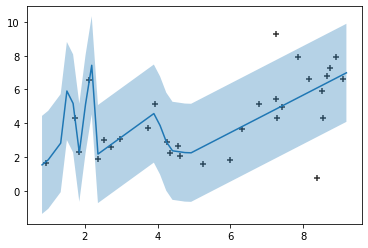

In [15]:
rwiggle = RWiggle()
rwiggle.load_state_dict(torch.load('Question(a)/RWiggle.pt'))

plt.scatter(x, y, color='black', marker='+', alpha=.8)
with torch.no_grad():
    xnew = torch.linspace(torch.min(x) - 0.1, torch.max(x) + 0.1, 50)[:, None]
    f = rwiggle.μ(xnew)
    σ = rwiggle.σ.item()
    plt.plot(xnew, f)
    plt.fill_between(xnew[:, 0], (f + 1.96 * σ)[:, 0], (f - 1.96 * σ)[:, 0], alpha=0.33)
    plt.savefig('Question(a)/RWiggle_plot.png', bbox_inches='tight')
    plt.show()

In [16]:
init_random_seed()

hwiggle = HWiggle()
epoch = 0
hwiggle_params = {
    'μ': [],
    'σ': [],
    'loglik': []
}

optimiser = optim.Adam(hwiggle.parameters())

while epoch < total_epochs:
    optimiser.zero_grad()
    loglik = torch.mean(hwiggle(y, x))
    hwiggle_params['μ'].append(hwiggle.μ(x))
    hwiggle_params['σ'].append(hwiggle.σ(x))
    hwiggle_params['loglik'].append(loglik)
    (-loglik).backward()
    optimiser.step()
    epoch += 1
    if epoch % 200 == 0:
        IPython.display.clear_output(wait=True)
        print(f'epoch={epoch} loglik={loglik.item():.4}')

IPython.display.clear_output(wait=True)
print(f'epoch={epoch} loglik={loglik.item():.4}')

torch.save(hwiggle.state_dict(), 'Question(a)/HWiggle.pt')
with open('Question(b)/HWiggle_params.pickle', 'wb') as f:
    pickle.dump(hwiggle_params, f)

epoch=50000 loglik=-0.5253


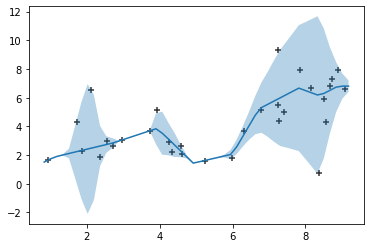

In [17]:
hwiggle = HWiggle()
hwiggle.load_state_dict(torch.load('Question(a)/HWiggle.pt'))

plt.scatter(x, y, color='black', marker='+', alpha=.8)
with torch.no_grad():
    xnew = torch.linspace(torch.min(x) - 0.1, torch.max(x) + 0.1, 50)[:, None]
    f = hwiggle.μ(xnew)
    σ = hwiggle.σ(xnew)
    plt.plot(xnew, f)
    plt.fill_between(xnew[:, 0], (f + 1.96 * σ)[:, 0], (f - 1.96 * σ)[:, 0], alpha=0.33)
    plt.savefig('Question(a)/HWiggle_plot.png', bbox_inches='tight')
    plt.show()

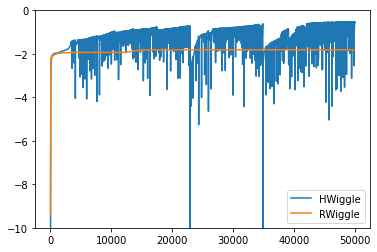

In [18]:
# Question (b)
epochs = np.arange(50000)
with open('Question(b)/RWiggle_params.pickle', 'rb') as f:
    rwiggle_params = pickle.load(f)
with open('Question(b)/HWiggle_params.pickle', 'rb') as f:
    hwiggle_params = pickle.load(f)

plt.plot(epochs + 1, torch.stack(hwiggle_params['loglik']).detach().numpy(), label='HWiggle')
plt.plot(epochs + 1, torch.stack(rwiggle_params['loglik']).detach().numpy(), label='RWiggle')
plt.ylim([-10, 0])
plt.legend()
plt.savefig('Question(b)/loglik_plot.png', bbox_inches='tight')
plt.show()

In [19]:
min_loglik_epoch = torch.argmin(torch.stack(hwiggle_params['loglik'][100:])) + 100
max_loglik_epoch = torch.argmax(torch.stack(hwiggle_params['loglik'][100:])) + 100
print(f'min_loglik_epoch: {min_loglik_epoch}, loglik={hwiggle_params["loglik"][min_loglik_epoch]}')
print(f'min_loglik_epoch: {max_loglik_epoch}, loglik={hwiggle_params["loglik"][max_loglik_epoch]}')

min_loglik_epoch: 34887, loglik=-30.002344131469727
min_loglik_epoch: 49446, loglik=-0.5165547132492065


In [20]:
# (μ_i, σ_i, (y_i - μ_i) ** 2) at the epoch with the lowest log.lik.
[(μ_i.item(), σ_i.item(), (y_i.item() - μ_i.item()) ** 2) for μ_i, σ_i, y_i in zip(hwiggle_params['μ'][min_loglik_epoch], hwiggle_params['σ'][min_loglik_epoch], y)]

[(1.6358743906021118, 0.002160863019526005, 1.5020725783188027e-06),
 (2.301800012588501, 1.2289514541625977, 3.9632852065347492),
 (2.3734354972839355, 1.7391489744186401, 0.009827827308072301),
 (2.5255532264709473, 2.9305813312530518, 16.14711089656703),
 (2.6798980236053467, 1.3334765434265137, 0.6310682926373943),
 (2.7870492935180664, 0.5266158580780029, 0.038829021666572316),
 (2.8929364681243896, 0.15914727747440338, 0.07763827435360326),
 (3.0399367809295654, 0.012011160142719746, 3.6762671754786425e-05),
 (3.744462013244629, 0.011267961002886295, 0.0018371457699686289),
 (4.027133941650391, 0.682141125202179, 1.2442646600911758),
 (3.2390079498291016, 0.6956158876419067, 0.11601372897126794),
 (3.026622772216797, 0.6935214400291443, 0.6322203654559075),
 (2.241988182067871, 0.24764564633369446, 0.14846521555824665),
 (2.081976890563965, 0.19629281759262085, 2.1373744004904438e-05),
 (1.6178479194641113, 0.041665297001600266, 1.8168328921319699e-06),
 (2.240326166152954, 0.010

In [21]:
# (μ_i, σ_i, (y_i - μ_i) ** 2) at the epoch with the highest log.lik.
[(μ_i.item(), σ_i.item(), (y_i.item() - μ_i.item()) ** 2) for μ_i, σ_i, y_i in zip(hwiggle_params['μ'][max_loglik_epoch], hwiggle_params['σ'][max_loglik_epoch], y)]

[(1.6370055675506592, 0.0014097723178565502, 8.91395757207647e-09),
 (2.2454166412353516, 1.4598792791366577, 4.190960338524974),
 (2.3175954818725586, 1.8513717651367188, 0.0018744902283742704),
 (2.470870018005371, 2.7444145679473877, 16.589573339881326),
 (2.626387357711792, 0.7476342916488647, 0.5489141446474264),
 (2.7343525886535645, 0.3199761211872101, 0.06237382111117995),
 (2.841196060180664, 0.16746722161769867, 0.051481816412945136),
 (3.045865058898926, 0.002653577132150531, 1.8210130292573012e-08),
 (3.7016072273254395, 0.004642033483833075, 5.1159076974727213e-11),
 (3.849703311920166, 0.9864614009857178, 1.6715819999265022),
 (3.0567727088928223, 0.5657612085342407, 0.02508189329370225),
 (2.8938210010528564, 0.5061179995536804, 0.43866922718370915),
 (2.291813850402832, 0.245553120970726, 0.11255097269673797),
 (2.1690454483032227, 0.16818799078464508, 0.0067972411898722385),
 (1.616424560546875, 0.0012854539090767503, 5.694133164979576e-09),
 (2.0656166076660156, 0.200

In [5]:
# Question (c)
class BernoulliImageGenerator(nn.Module):
    def __init__(self, d=4):
        super().__init__()
        self.d = d
        self.f = nn.Sequential(
            nn.Linear(d, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 1728),
            nn.LeakyReLU(),
            nn.Unflatten(1, (12,12,12)), # -> [B×12×12×12]
            nn.Conv2d(12, 36, 3, 1),     # -> [B×36×10×10]
            nn.LeakyReLU(),
            nn.Flatten(1),               # -> [B×3600]
            nn.Unflatten(1, (4,30,30)),  # -> [B×4×30×30]
            nn.Conv2d(4, 4, 3, 1),       # -> [B×4×28×28]
            nn.LeakyReLU(),
            nn.Conv2d(4, 1, 1, 1),       # -> [B×1×28×28]
            nn.Sigmoid()
        )

    def forward(self, z):
        return self.f(z)

    def loglik(self, x, z):
        xr = self(z)
        return (x * torch.log(xr) + (1 - x) * torch.log(1 - xr)).sum((1, 2, 3))


class GaussianEncoder(nn.Module):
    def __init__(self, decoder):
        super().__init__()
        self.d = decoder.d
        self.f = decoder
        self.g = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1),
            nn.LeakyReLU(),
            nn.Conv2d(32, 64, 3, 1),
            nn.MaxPool2d(2),
            nn.Flatten(1),
            nn.Linear(9216, 128),
            nn.LeakyReLU(),
            nn.Linear(128, self.d*2)
        )

    def forward(self, x):
        μτ = self.g(x)
        μ,τ = μτ[:, :self.d], μτ[:, self.d:]
        return μ, torch.exp(τ/2)

    def loglik_lb(self, x):
        μ,σ = self(x)
        kl = 0.5 * (μ**2 + σ**2 - torch.log(σ**2) - 1).sum(1)
        ε = torch.randn_like(σ)
        ll = self.f.loglik(x, z=μ + σ * ε)
        return ll - kl

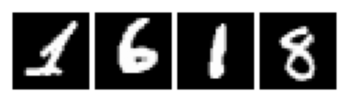

In [9]:
show = [mnist[i] for i in [59289, 28001, 35508, 43876]]
show = torch.stack([img for img, lbl in show])
show_imgs = torchvision.utils.make_grid(show, nrow=4, pad_value=1)
plt.imshow(show_imgs.numpy().transpose((1,2,0)))
plt.axis('off')
plt.savefig(f'Question(c)/original_imgs.png', bbox_inches='tight')
plt.show()

In [46]:
init_random_seed()

model = GaussianEncoder(BernoulliImageGenerator(d=4))
optimiser = optim.Adam(model.parameters())
epoch = 0
total_epochs = 5

while epoch < total_epochs:
    loglik_lbs = []
    for batch_num, (imgs, lbls) in enumerate(mnist_train_batched):
        optimiser.zero_grad()
        loglik_lb = torch.mean(model.loglik_lb(imgs))
        loglik_lbs.append(loglik_lb)
        (-loglik_lb).backward()
        optimiser.step()
    epoch += 1
    IPython.display.clear_output(wait=True)
    loglik_lb = torch.mean(torch.stack(loglik_lbs))
    print(f'epoch={epoch} loglik={loglik_lb.item():.4}')

IPython.display.clear_output(wait=True)
print(f'epoch={epoch} loglik={loglik_lb.item():.4}')

torch.save(model.state_dict(), 'Question(c)/Autoencoder(c).pt')

epoch=5 loglik=-131.0


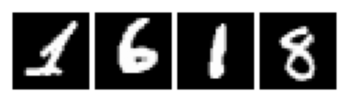

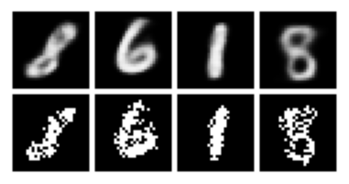

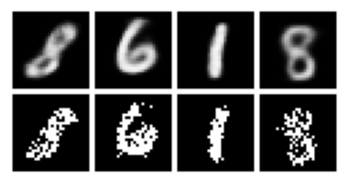

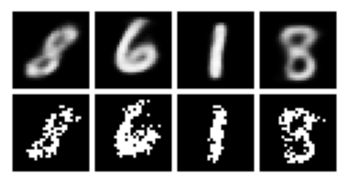

In [72]:
init_random_seed()

plt.imshow(show_imgs.numpy().transpose((1, 2, 0)))
plt.axis('off')
plt.show()

model = GaussianEncoder(BernoulliImageGenerator(d=4))
model.load_state_dict(torch.load('Question(c)/Autoencoder(c).pt'))

for i in range(3):    
    μ, σ = model(show)
    ε = torch.randn_like(σ)
    z = µ + σ * ε
    p = model.f(z).detach()
    x = torch.bernoulli(p)
    
    output = torchvision.utils.make_grid(torch.cat((p, x)), nrow=4, pad_value=1)
    plt.imshow(output.numpy().transpose((1, 2, 0)))
    plt.axis('off')
    plt.savefig(f'Question(c)/reconstructed_imgs_{i + 1}.png', bbox_inches='tight')
    plt.show()

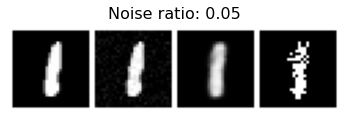

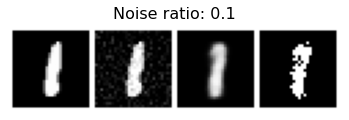

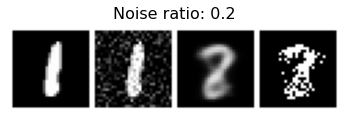

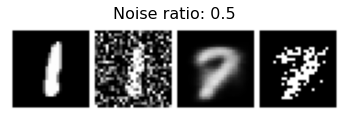

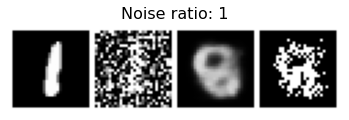

In [67]:
init_random_seed()

original = mnist[35508][0]
model = GaussianEncoder(BernoulliImageGenerator(d=4))
model.load_state_dict(torch.load('Question(c)/Autoencoder(c).pt'))

for noise_ratio in [0.05, 0.1, 0.2, 0.5, 1]:
    noise = torch.randn_like(original) * noise_ratio
    perturbed = (original + noise).clamp(0, 1)
    μ, σ = model(torch.stack([perturbed] * 4))
    ε = torch.randn_like(σ)
    z = µ + σ * ε
    p = model.f(z).detach()
    x = torch.bernoulli(p)
    output = torchvision.utils.make_grid([original, perturbed, p[0], x[0]], nrow=4, pad_value=1)
    plt.imshow(output.numpy().transpose((1,2,0)))
    plt.axis('off')
    plt.title(f'Noise ratio: {noise_ratio}', fontsize=16)
    plt.savefig(f'Question(c)/reconstructed_imgs_noise_{noise_ratio}.png', bbox_inches='tight')
    plt.show()

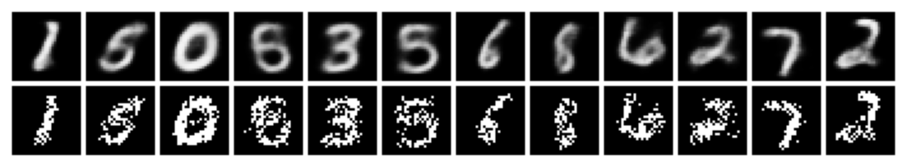

In [65]:
init_random_seed()

model = GaussianEncoder(BernoulliImageGenerator(d=4))
model.load_state_dict(torch.load('Question(c)/Autoencoder(c).pt'))

ps = []
xs = []
for i in range(3):
    z = torch.randn_like(σ)
    p = model.f(z).detach()
    ps.extend(p)
    x = torch.bernoulli(p)
    xs.extend(x)
                 
output = ps
output.extend(xs)
output = torchvision.utils.make_grid(output, nrow=12, pad_value=1)
plt.figure(figsize=(16, 6))
plt.imshow(output.numpy().transpose((1,2,0)))
plt.axis('off')
plt.savefig(f'Question(c)/random_imgs.png', bbox_inches='tight')
plt.show()

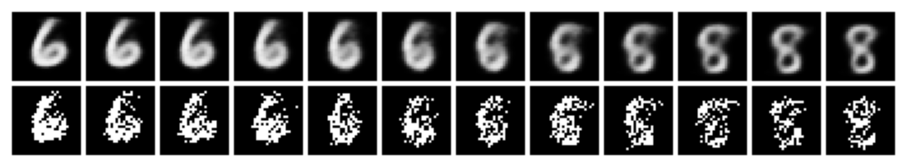

In [58]:
model = GaussianEncoder(BernoulliImageGenerator(d=4))
model.load_state_dict(torch.load('Question(c)/Autoencoder(c).pt'))

imgs = [mnist[i][0] for i in [28001, 43876]]
imgs = torch.stack(imgs)
μ, σ = model(imgs)
ε = torch.randn_like(σ)
z = µ + σ * ε
lerp = [z[0]]
for i in range(1, 11):
    lerp.append(torch.lerp(z[0], z[1], i / 11))
lerp.append(z[1])
lerp = torch.stack(lerp)
lerp_batched = torch.utils.data.DataLoader(lerp, batch_size=4)
ps = []
xs = []
for batch in lerp_batched:
    p = model.f(batch).detach()
    ps.extend(p)
    x = torch.bernoulli(p)
    xs.extend(x)
    
output = ps
output.extend(xs)
output = torchvision.utils.make_grid(output, nrow=12, pad_value=1)
plt.figure(figsize=(16, 6))
plt.imshow(output.numpy().transpose((1,2,0)))
plt.axis('off')
plt.savefig(f'Question(c)/lerp_imgs.png', bbox_inches='tight')
plt.show()

In [6]:
# Question (d)
def loglik_lb_monte_carlo(model, x, m=100):
    μ,σ = model(x)
    kl = 0.5 * (μ**2 + σ**2 - torch.log(σ**2) - 1).sum(1)
    lls = []
    for i in range(m):
        ε = torch.randn_like(σ)
        lls.append(model.f.loglik(x, z=μ + σ * ε))
    ll = sum(lls) / len(lls)
    return ll - kl

In [8]:
model = GaussianEncoder(BernoulliImageGenerator(d=4))
model.load_state_dict(torch.load('Question(c)/Autoencoder(c).pt'))

img_loglik = {}
for batch_num, (imgs, lbls) in enumerate(mnist_train_batched):
    img_loglik_batched = loglik_lb_monte_carlo(model, imgs)
    for i, img in enumerate(imgs):
        img_loglik[img] = img_loglik_batched[i].item()
    IPython.display.clear_output(wait=True)
    print(f'{batch_num + 1}/{len(mnist_train_batched)} batches completed.')

img_loglik_sorted = dict(sorted(img_loglik.items(), key=lambda item: item[1]))
with open('Question(d)/img_loglik_sorted.pickle', 'wb') as f:
    pickle.dump(img_loglik_sorted, f)

540/540 batches completed.


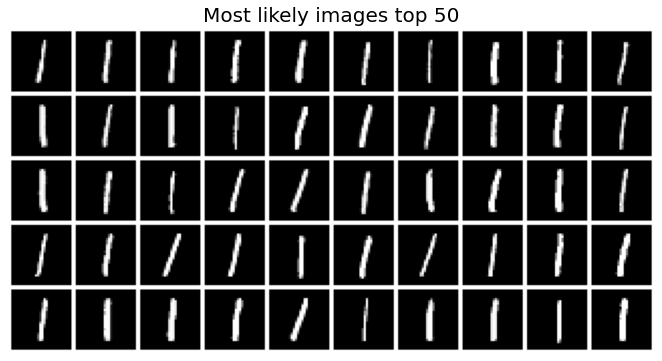

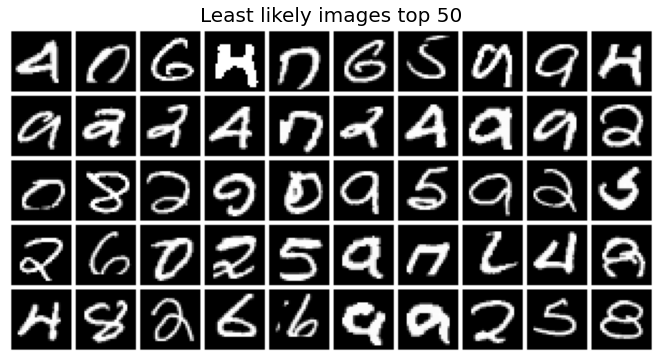

In [15]:
# with open('Question(d)/img_loglik_sorted.pickle', 'rb') as f:
#     img_loglik_sorted = pickle.load(f)

most_likely_imgs = torch.stack([img for img, loglik in list(img_loglik_sorted.items())[-50:]])
most_likely_imgs = torchvision.utils.make_grid(most_likely_imgs, nrow=10, pad_value=1)
plt.figure(figsize=(16, 6))
plt.imshow(most_likely_imgs.numpy().transpose((1,2,0)))
plt.axis('off')
plt.title('Most likely images top 50', fontsize=20)
plt.savefig('Question(d)/most_likely_imgs.png', bbox_inches='tight')
plt.show()

least_likely_imgs = torch.stack([img for img, loglik in list(img_loglik_sorted.items())[:50]])
least_likely_imgs = torchvision.utils.make_grid(least_likely_imgs, nrow=10, pad_value=1)
plt.figure(figsize=(16, 6))
plt.imshow(least_likely_imgs.numpy().transpose((1,2,0)))
plt.axis('off')
plt.title('Least likely images top 50', fontsize=20)
plt.savefig('Question(d)/least_likely_imgs.png', bbox_inches='tight')
plt.show()

In [10]:
# Question (e)
init_random_seed()

model = GaussianEncoder(BernoulliImageGenerator(d=20))
optimiser = optim.Adam(model.parameters())
epoch = 0
total_epochs = 5

while epoch < total_epochs:
    loglik_lbs = []
    for batch_num, (imgs, lbls) in enumerate(mnist_train_batched):
        optimiser.zero_grad()
        loglik_lb = torch.mean(model.loglik_lb(imgs))
        loglik_lbs.append(loglik_lb)
        (-loglik_lb).backward()
        optimiser.step()
    epoch += 1
    IPython.display.clear_output(wait=True)
    loglik_lb = torch.mean(torch.stack(loglik_lbs))
    print(f'epoch={epoch} loglik={loglik_lb.item():.4}')

IPython.display.clear_output(wait=True)
print(f'epoch={epoch} loglik={loglik_lb.item():.4}')

torch.save(model.state_dict(), 'Question(e)/Autoencoder(e).pt')

epoch=5 loglik=-123.9


In [6]:
autoencoder_d4 = GaussianEncoder(BernoulliImageGenerator(d=4))
autoencoder_d4.load_state_dict(torch.load('Question(c)/Autoencoder(c).pt'))

test_loglik_lbs = []
for batch_num, (imgs, lbls) in enumerate(mnist_test_batched):
    test_loglik_lbs.append(torch.mean(autoencoder_d4.loglik_lb(imgs)))
test_loglik_lb = torch.mean(torch.stack(test_loglik_lbs))

print(f'd=4:  holdout loglik_lb={test_loglik_lb.item():.4}')

autoencoder_d20 = GaussianEncoder(BernoulliImageGenerator(d=20))
autoencoder_d20.load_state_dict(torch.load('Question(e)/Autoencoder(e).pt'))

test_loglik_lbs = []
for batch_num, (imgs, lbls) in enumerate(mnist_test_batched):
    test_loglik_lbs.append(torch.mean(autoencoder_d20.loglik_lb(imgs)))
test_loglik_lb = torch.mean(torch.stack(test_loglik_lbs))

print(f'd=20: holdout loglik_lb={test_loglik_lb.item():.4}')

d=4:  holdout loglik_lb=-129.3
d=20: holdout loglik_lb=-121.2


In [76]:
# Question (f)
class ConditionalBernoulliImageGenerator(nn.Module):
    def __init__(self, d=4):
        super().__init__()
        self.d = d
        self.f = nn.Sequential(
            nn.Linear(d + 10, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 1728),
            nn.LeakyReLU(),
            nn.Unflatten(1, (12,12,12)), # -> [B×12×12×12]
            nn.Conv2d(12, 36, 3, 1),     # -> [B×36×10×10]
            nn.LeakyReLU(),
            nn.Flatten(1),               # -> [B×3600]
            nn.Unflatten(1, (4,30,30)),  # -> [B×4×30×30]
            nn.Conv2d(4, 4, 3, 1),       # -> [B×4×28×28]
            nn.LeakyReLU(),
            nn.Conv2d(4, 1, 1, 1),       # -> [B×1×28×28]
            nn.Sigmoid()
        )

    def forward(self, z, y):
        return self.f(torch.cat((z, y), dim=1))

    def loglik(self, x, z, y):
        xr = self(z, y)
        return (x * torch.log(xr) + (1 - x) * torch.log(1 - xr)).sum((1, 2, 3))


class ConditionalGaussianEncoder(nn.Module):
    def __init__(self, decoder):
        super().__init__()
        self.d = decoder.d
        self.f = decoder
        self.g = nn.Sequential(
            nn.Linear(28 * 28 + 10, 512),
            nn.LeakyReLU(),
            nn.Linear(512, 512),
            nn.LeakyReLU(),
            nn.Linear(512, 512),
            nn.LeakyReLU(),
            nn.Linear(512, 128),
            nn.LeakyReLU(),
            nn.Linear(128, self.d*2)
        )

    def forward(self, x, y):
        x = torch.flatten(x, start_dim=1)
        μτ = self.g(torch.cat((x, y), dim=1))
        μ, τ = μτ[:, :self.d], μτ[:, self.d:]
        return μ, torch.exp(τ/2)

    def loglik_lb(self, x, y):
        μ, σ = self(x, y)
        kl = 0.5 * (μ**2 + σ**2 - torch.log(σ**2) - 1).sum(1)
        ε = torch.randn_like(σ)
        ll = self.f.loglik(x, z=μ + σ * ε, y=y)
        return ll - kl

In [81]:
def one_hot(y):
    c = torch.zeros(y.shape[0], 10)
    for i, y_i in enumerate(y):
        c[i, y_i] = 1
    return c

In [83]:
init_random_seed(0)

model = ConditionalGaussianEncoder(ConditionalBernoulliImageGenerator(d=4))
optimiser = optim.Adam(model.parameters())
epoch = 0
total_epochs = 5

while epoch < total_epochs:
    loglik_lbs = []
    for batch_num, (imgs, lbls) in enumerate(mnist_train_batched):
        optimiser.zero_grad()
        lbls_onehot = one_hot(lbls)
        loglik_lb = torch.mean(model.loglik_lb(imgs, lbls_onehot))
        loglik_lbs.append(loglik_lb)
        (-loglik_lb).backward()
        optimiser.step()
    epoch += 1
    IPython.display.clear_output(wait=True)
    loglik_lb = torch.mean(torch.stack(loglik_lbs))
    print(f'epoch={epoch} loglik={loglik_lb.item():.4}')

IPython.display.clear_output(wait=True)
print(f'epoch={epoch} loglik={loglik_lb.item():.4}')

torch.save(model.state_dict(), 'Question(f)/ConditionalAutoencoder.pt')

epoch=5 loglik=-131.5


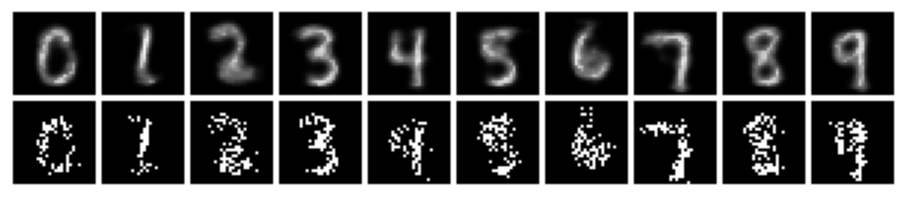

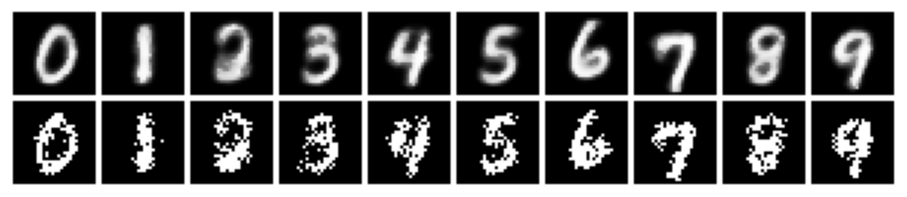

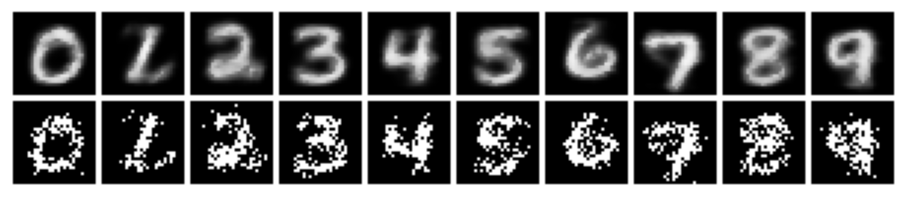

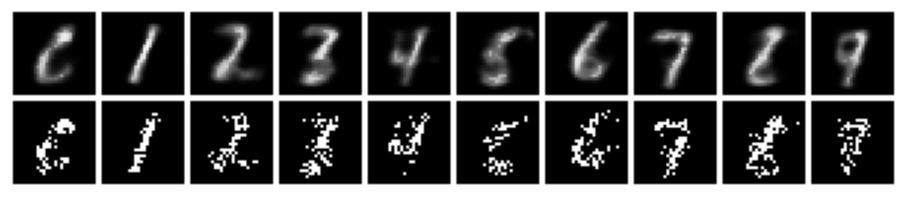

In [97]:
model = ConditionalGaussianEncoder(ConditionalBernoulliImageGenerator(d=4))
model.load_state_dict(torch.load('Question(f)/ConditionalAutoencoder.pt'))

for i in range(4):
    z = torch.randn_like(σ) 
    ps = []
    xs = []
    for y in range(10):
        p = model.f(z, one_hot(torch.tensor([y]))).detach()
        ps.extend(p)
        x = torch.bernoulli(p)
        xs.extend(x)
    
    output = ps
    output.extend(xs)
    output = torchvision.utils.make_grid(output, nrow=10, pad_value=1)
    plt.figure(figsize=(16, 6))
    plt.imshow(output.numpy().transpose((1,2,0)))
    plt.axis('off')
    plt.savefig(f'Question(f)/style_{i + 1}.png', bbox_inches='tight')
    plt.show()